In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

In [6]:
run_in_jupyter = False
try:
    cfg = get_ipython().config 
    run_in_jupyter = True
except:
    run_in_jupyter = False
    pass

In [38]:
if run_in_jupyter:
    %run dataset.py
    %run utils/power_spectrum_utils.py
else:
    from dataset import *
    from utils.power_spectrum_utils import *

In [13]:
cube_size = 128 

In [14]:
test_coords = define_test(s_test = 1024, s_train = cube_size)
test_coords

{'x': [896, 1920], 'y': [128, 1152], 'z': [512, 1536]}

In [15]:
data_dir = "../"
redshift_raw_file = "fields_z=0.0.hdf5"


In [16]:
f = h5py.File(data_dir + redshift_raw_file, 'r')
print("File used for analysis = " + str(f.filename))
f = f['delta_HI']

File used for analysis = ../fields_z=0.0.hdf5


In [25]:
number_of_samples = 5

In [21]:
sampled_cube = get_samples(f=f,nsamples=number_of_samples,s_sample=cube_size,test_coords=test_coords)
# sampled_cube = sampled_cube[0]
print(len(sampled_cube))


5


In [24]:
np.array(sampled_cube).shape

(5, 128, 128, 128)

In [26]:
sampled_cube = np.array(sampled_cube).reshape(number_of_samples, 1 , cube_size, cube_size, cube_size)
sampled_cube.shape



(5, 1, 128, 128, 128)

In [18]:
root_dir = "./"
experiment = root_dir + "mmd-jupyter/"
redshift_info_folder = experiment + "redshift_info/"
mean_raw_cube = np.load(file = redshift_info_folder + redshift_raw_file + "_mean_cube" + '.npy')
mean_raw_cube

array(10170.682, dtype=float32)

In [28]:
noise_sampled_cube = get_samples(f=f,nsamples=number_of_samples,s_sample=cube_size,test_coords=test_coords)
# sampled_cube = sampled_cube[0]
# print(noise_sampled_cube.shape)
noise_sampled_cube = np.array(noise_sampled_cube).reshape(number_of_samples, 1 , cube_size, cube_size, cube_size)
noise_sampled_cube.shape



(5, 1, 128, 128, 128)

number of samples of real and generated cubes = 5


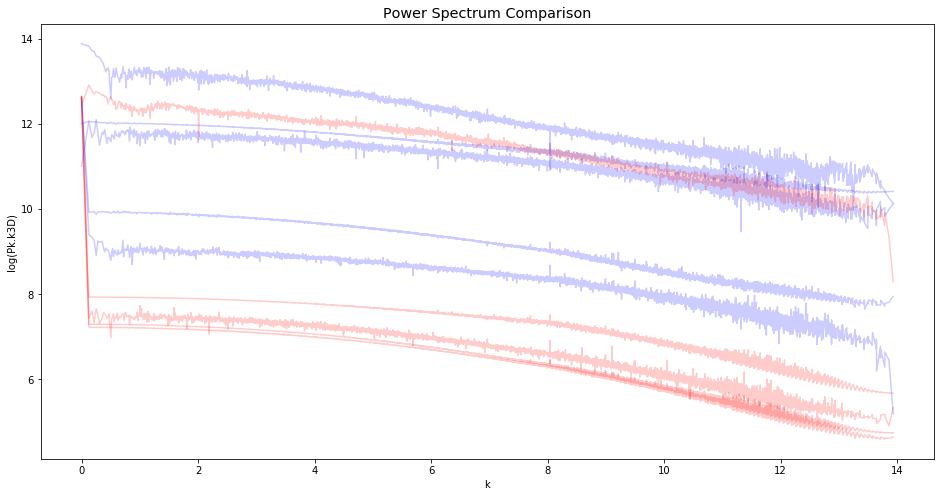

'Power spectrum plot complete!'

In [39]:
plot_power_spec(real_cube = sampled_cube,        # should be inverse_transformed
                generated_cube = noise_sampled_cube,   # should be inverse_transformed
                raw_cube_mean = mean_raw_cube,    # mean of the whole raw data cube (fields=z0.0)
                threads=1, 
                MAS="CIC", 
                axis=0, 
                BoxSize=75.0/2048*128)

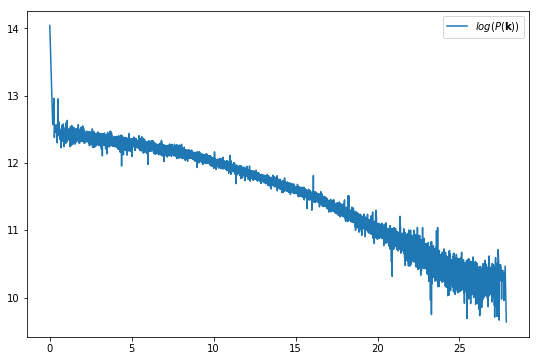

In [33]:
import numpy as np
import matplotlib.pyplot as plt


#==================================
def main():
#==================================


    nc = cube_size                # define how many cells your box has
    boxlen = 50.0           # define length of box
    Lambda = boxlen/4.0     # define an arbitrary wave length of a plane wave
    dx = boxlen/nc          # get size of a cell

    # create plane wave density field
#     density_field = np.zeros((nc, nc, nc), dtype='float')
#     for x in range(density_field.shape[0]):
#         density_field[x,:,:] = np.cos(2*np.pi*x*dx/Lambda)
    density_field = sampled_cube

#    # get overdensity field
#     delta = density_field/np.mean(density_field) - 1
    delta = density_field / mean_raw_cube - 1


    # get P(k) field: explot fft of data that is only real, not complex
    delta_k = np.abs(np.fft.rfftn(delta).round())
    Pk_field =  delta_k**2

    # get 3d array of index integer distances to k = (0, 0, 0)
    dist = np.minimum(np.arange(nc), np.arange(nc,0,-1))
    dist_z = np.arange(nc//2+1)
    dist *= dist
    dist_z *= dist_z
    dist_3d = np.sqrt(dist[:, None, None] + dist[:, None] + dist_z)

    # get unique distances and index which any distance stored in dist_3d 
    # will have in "distances" array
    distances, _ = np.unique(dist_3d, return_inverse=True)

    # average P(kx, ky, kz) to P(|k|)
    Pk = np.bincount(_, weights=Pk_field.ravel())/np.bincount(_)

    # compute "phyical" values of k
    dk = 2*np.pi/boxlen
    k = distances*dk

    # plot results
    fig = plt.figure(figsize=(9,6))
    ax1 = fig.add_subplot(111)
#     ax1.plot(k, Pk, label=r'$P(\mathbf{k})$')
    ax1.plot(k, np.log10(Pk), label=r'$log(P(\mathbf{k}))$')

    # plot expected peak:
    # k_peak = 2*pi/lambda, where we chose lambda for our planar wave earlier
#     ax1.plot([2*np.pi/Lambda]*2, [Pk.min()-1, Pk.max()+1], label='expected peak')
    ax1.legend()
    plt.show()
    
#==================================
if __name__ == "__main__":
#==================================

    main()